# Imports and constants

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import matthews_corrcoef, precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import cross_validate, StratifiedKFold
from imblearn.over_sampling import SMOTE, ADASYN
from imblearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.calibration import CalibrationDisplay, CalibratedClassifierCV
from sklearn.inspection import permutation_importance
from sklearn.preprocessing import Normalizer, StandardScaler

mpl.rcParams["figure.figsize"] = (6, 4)
pd.set_option("display.max_colwidth", None)
pd.set_option('display.max_rows', None)

PRIMARY_COLOR = "#C71918" # Main color used for some plots.
ROUND = 2 # Number of decimals to round to.

PROJECT_NAME = "sweethome3d"
LABELS = ["Controller", "Coordinator", "Information Holder", "Interfacer", "Service Provider", "Structurer"]
LABELS_ABBREVIATED = ["CT", "CO", "IH", "IT", "SP", "ST"]

RANDOM_SEED = 41 # RNG for random_state option.
K = 10 # Number of folds to
cv = StratifiedKFold(n_splits=K) # Cross-validation strategy.
# class_weights = {"Controller":1, "Coordinator":20, "Information Holder":0.5, "Interfacer":0.5, "Service Provider":0.5, "Structurer":20}

# Helper methods.

#### Load data, transform categorical features, define training pipelines and some convenience methods.

In [93]:
# Methods to one hot encode categorical features, credits to replication package provided by the paper of Ho-Quang et al.
def get_one_hot_encoding(data):
    cat_publicity = pd.get_dummies(data, prefix=['classPublicity'])
    cat_publicity = cast_to_categorical(cat_publicity)
    return cat_publicity

def cast_to_categorical(data):
    non_categorical= data.select_dtypes(include=['object', 'bool', 'uint8']).copy()
    column_list = non_categorical.columns.values.tolist()
    for column in column_list:
        data[column] = data[column].astype('category')
    return data

def cast_to_num(data):
    categorical= data.select_dtypes(include=['category']).copy()
    column_list = categorical.columns.values.tolist()
    for column in column_list:
        data[column] = data[column].astype('int64')
    return data


# Define training pipelines.
def get_pipeline(resampler: str, model: str):
    resampler = resampler.lower()
    model = model.lower()
    pipe = Pipeline(steps=[])
    
    if model == "svm":
        pipe.steps.append(["scaler", StandardScaler()])
    
    if model == "mnb": # MNB doesn't work with negative values, so replace the -1's with 0's.
        pipe.steps.append(["imputer", SimpleImputer(missing_values=-1, fill_value=0, strategy="constant")])
    
    if resampler == "smote":
        pipe.steps.append(["resampler", SMOTE(random_state=RANDOM_SEED)])
    
    # pipe.steps.append(['normalizer', Normalizer()])
        
    if model == "rf":
        pipe.steps.append(["clf", RandomForestClassifier(n_estimators=1000, random_state=RANDOM_SEED, n_jobs=-1)])
    elif model == "svm":
        pipe.steps.append(["clf", SVC(kernel='linear', C=1, random_state=RANDOM_SEED)])
    elif model == "mnb":
        pipe.steps.append(["clf", MultinomialNB()])
    
    return pipe


# Load dataset.
def load_data(data_path: str, drop_cols: list = [], cat_features: list = None, filter_name: str = None):
    raw_data = pd.read_csv(data_path)
    raw_data = raw_data.drop(raw_data[raw_data['label'] == 'DISCARD'].index) # Drop classes that have label == "DISCARD".
    
    if not filter_name is None: # Filter is only used for the CSV of the paper because that CSV also includes other projects like K9-Mail.
        raw_data = raw_data[raw_data["fullpathname"].str.contains(filter_name, case=False)]
    
    if "fullpathname" in raw_data.columns.tolist(): # Only applicable to CSV of paper because they use a different notation for class names.
        raw_data["className"] = raw_data_paper["fullpathname"].apply(lambda x: convert_name(x))
        raw_data = raw_data.drop(columns=["classname", "fullpathname"])
    
    y = raw_data["label"]
    X = raw_data.drop(columns=["label"])
    X = X.drop(columns=drop_cols)
    
    if not cat_features is None:
        X = get_one_hot_encoding(X.drop(columns=["className"]))
        X = cast_to_num(X)
        X = pd.concat([raw_data["className"], X], axis=1)
                                 
    full_data = pd.concat([X, y], axis=1)
    
    return X, y, full_data


# Convenience methods for printing scores and converting class name notation.
def format_std(score, std):
    return "{:.2f}±{:.2f}".format(score, std)

def print_scores(scores_dict: dict):
    print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("CONFIG", "PREC", "REC", "F1", "MCC"))
    for alg, score in scores_dict.items():
        print("{:<20} {:<10} {:<10} {:<10} {:<10}".
              format(alg, format_std(score['prec'], score['prec_std']), 
                                     format_std(score['rec'], score['rec_std']), 
                                     format_std(score['f1'], score['f1_std']), 
                                     format_std(score['mcc'], score['mcc_std'])))

def convert_name(class_name):
    class_name = class_name.removeprefix("\src\\")
    class_name = class_name.removesuffix(".java")
    class_name = class_name.replace(".", "$")
    class_name = class_name.replace("\\", ".")

    return class_name

# Loading the data (SweetHome3D)

#### Our own dataset (i.e. the dynamic features).

In [140]:
PROJECT_NAME = "sweethome3d"
# Our own dataset (i.e. based on dynamic features) - 501 classes.
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/features_{PROJECT_NAME}_FINAL_v4_RELABELED2.csv"        
X, y, data = load_data(data_path)


# Dataset of the paper (i.e. based on static features, but only classes that are from SweetHome3D) - 546 classes.
data_path_paper_546 = "/Users/mboopi/Documents/GitHub/jss_role_experiments/dataset/three/three-cases-20190301.csv"
drop_cols_paper = ["index"]
cat_features = ["classPublicity"]
X_paper_546, y_paper_546, data_paper_546 = load_data(data_path_paper_546, drop_cols_paper, cat_features, filter_name=PROJECT_NAME)


# Dataset of the paper (but only the classes that are present in both of the previous datasets) - 501 classes.
merged_data = pd.merge(data[["className", "label"]], data_paper_546, on="className", how="inner")
y_paper_501 = merged_data["label_x"]
y_paper_501.name = "label"
X_paper_501 = merged_data.drop(columns=["label_y", "label_x"])


# Combined dataset (i.e. both dynamic + static features) - 501 classes.
combined_data = pd.merge(data, data_paper_546, on="className", how="inner")
y_combined = combined_data["label_x"]
y_combined.name = "label"
X_combined = combined_data.drop(columns=["label_y", "label_x"])

# Exploratory code

#### Label distribution, feature correlation and feature value distribution.

Information Holder    167
Service Provider      120
Interfacer             81
Coordinator            72
Controller             37
Structurer             24
Name: label, dtype: int64


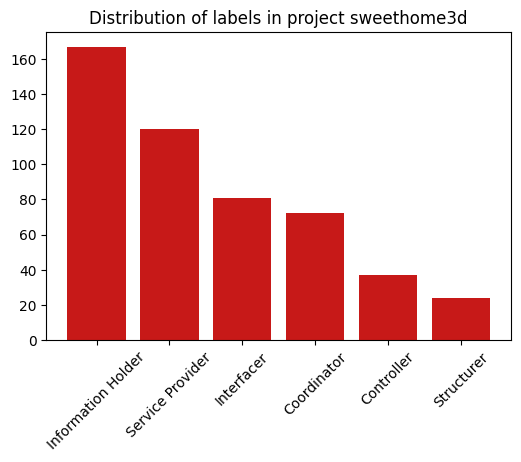

Average correlation of each feature, to any other feature:
numIntCalls               0.440271
numExtCalls_A             0.396773
numExtCalls_B             0.425950
ratioInternalExternal     0.100182
numIncomingCalls_A        0.300391
numIncomingCalls_B        0.171584
numOutgoingCalls_A        0.479076
numOutgoingCalls_B        0.460668
ratioIncomingOutgoing     0.095525
numUniqueIncomingCalls    0.272059
numUniqueOutgoingCalls    0.233741
numObjectsCreated         0.359146
percObjectCreation        0.095042
numLeaves                 0.304041
percLeaves                0.068042
avgExecTime               0.007432
avgDepth                 -0.031370
numObjectsTotal           0.166585
numObjectsDeallocated     0.179446
percDeallocated           0.066071
avgObjectSize             0.024216
dtype: float64


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3430: FutureWarning: In a future version, DataFrame.mean(axis=None) will return a scalar mean over the entire DataFrame. To retain the old behavior, use 'frame.mean(axis=0)' or just 'frame.mean()'
  return mean(axis=axis, dtype=dtype, out=out, **kwargs)


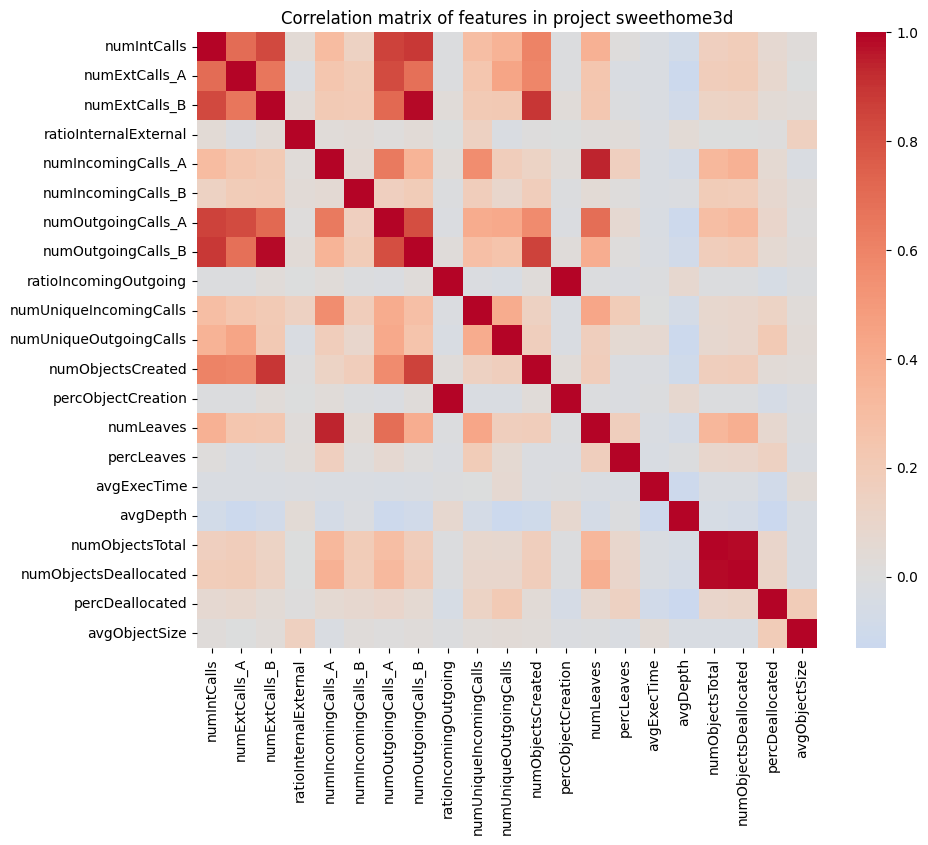

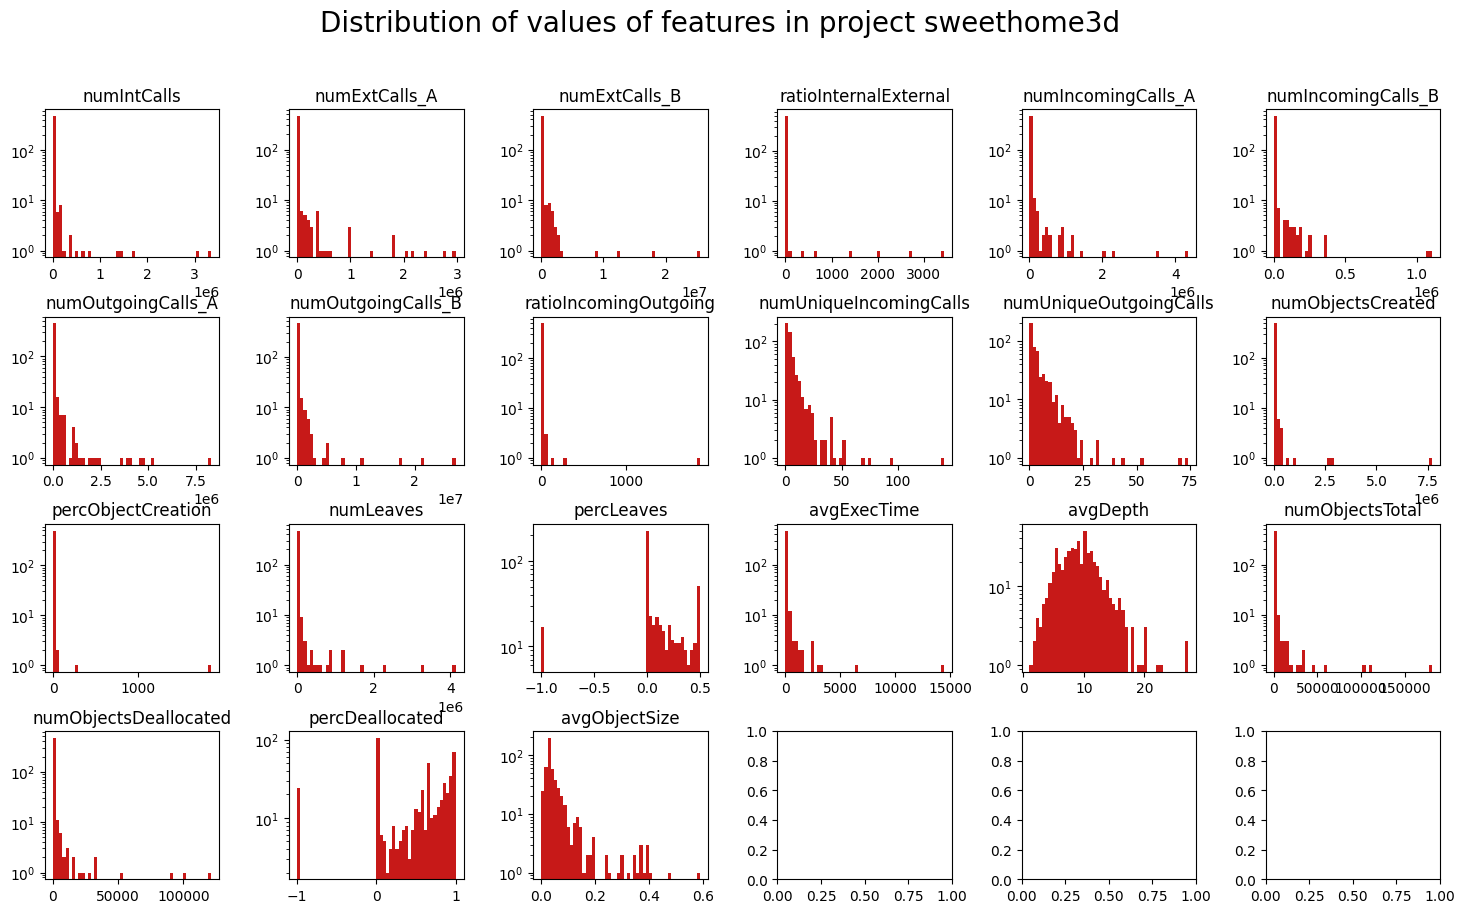

In [6]:
X = X.drop(columns=["className"])

# Check distribution of the labels in the dataset.
frequencies = y.value_counts()
print(frequencies)

plt.bar(frequencies.index, frequencies.values, color=PRIMARY_COLOR)
plt.title(f"Distribution of labels in project {PROJECT_NAME}")
plt.xticks(rotation=45)
plt.show()


# Check feature correlation by computing a correlation matrix that shows the Pearson correlation coefficient (r) between each pair of features. 
# This r is a measure of the linear relationship between 2 variables. It ranges from -1 (perfect negative correlation) to 1 (perfect positive correlation), 
# with 0 indicating no correlation.
corr_matrix = X.corr()
mask = np.triu(np.ones_like(corr_matrix, dtype=bool)) # Compute the average value of r by converting df to np array.
                                                      # Compute the average only on the upper triangle of the matrix, excluding diagonals.
avg_r = np.mean(corr_matrix[mask]) 
print("Average correlation of each feature, to any other feature:")
print(avg_r)

mpl.rcParams["figure.figsize"] = (10, 8) # Otherwise some rows will be missing from the plot.
sns.heatmap(corr_matrix, cmap="coolwarm", center=0);
plt.title(f"Correlation matrix of features in project {PROJECT_NAME}")
mpl.rcParams["figure.figsize"] = (6, 4)

# Plot distribution of each feature.
columns = X.columns.tolist()
num_features = X.shape[1]

fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10))
fig.suptitle(f"Distribution of values of features in project {PROJECT_NAME}", fontsize=20)
axs = axs.flatten()
for i in range(num_features):
    col_name = columns[i]
    axs[i].hist(X[col_name], bins=50, color=PRIMARY_COLOR, log=True)
    axs[i].set_title(col_name)

plt.subplots_adjust(wspace=0.4, hspace=0.4)
plt.show()  


# Some extra sanity checks to validate the values of our features.
# rounding = 3
# for feature in columns:
#     min_val = X[feature].min().round(rounding)
#     max_val = X[feature].max().round(rounding)
#     avg_val = X[feature].mean().round(rounding)
#     std_val = X[feature].std().round(rounding)
#     med_val = X[feature].median().round(rounding)
#     print(f"{feature}: MIN - MAX - MEAN - STD - MEDIAN")
#     print(f"{min_val} - {max_val} - {avg_val} - {std_val} - {med_val}")
#     print("\n")
    

#### Feature value distribution per role.

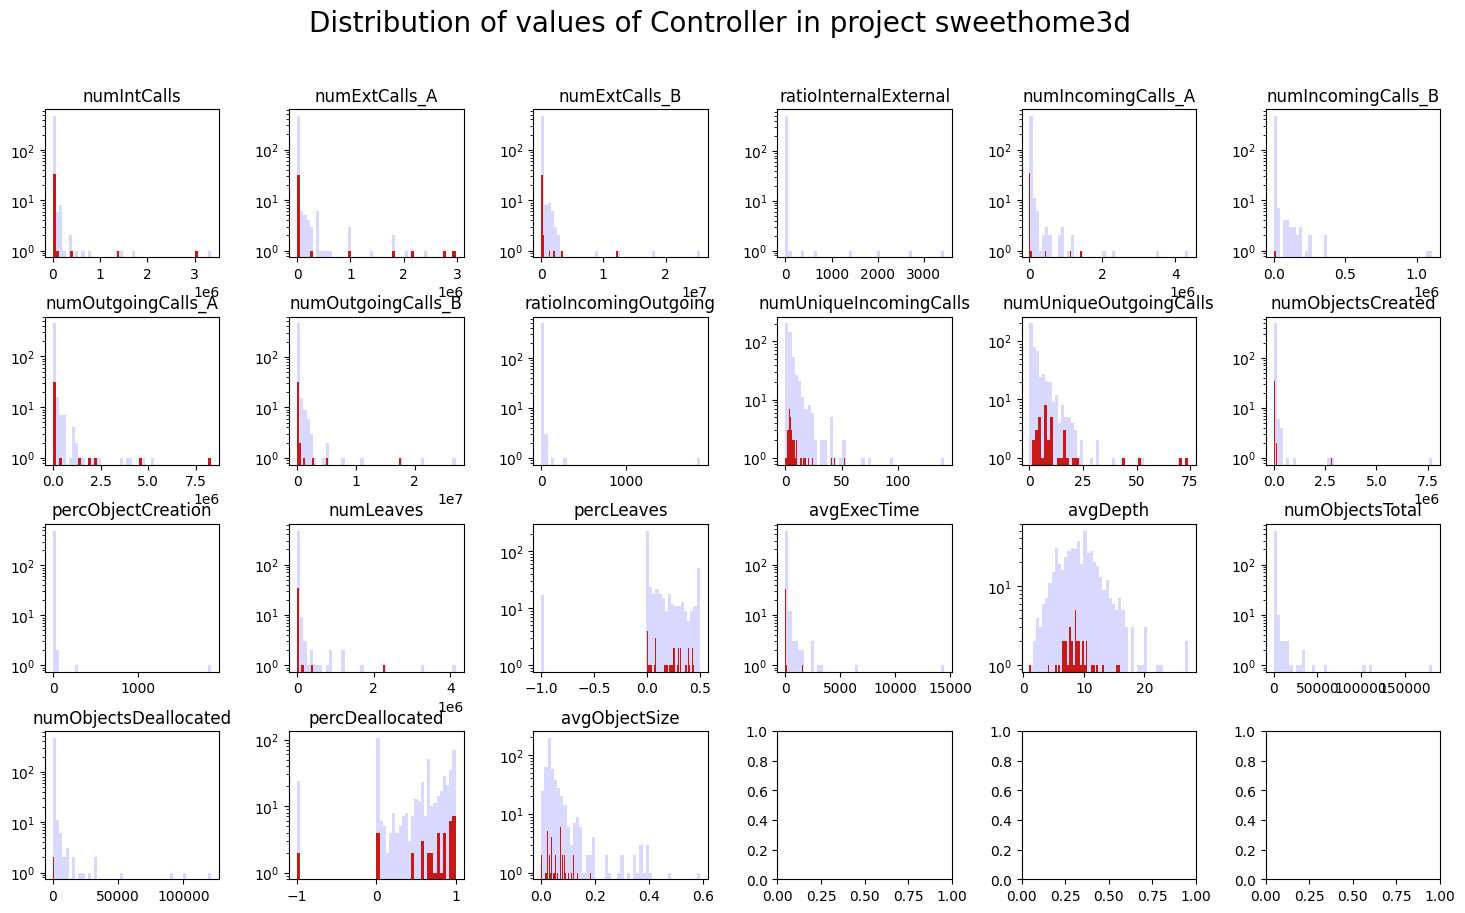

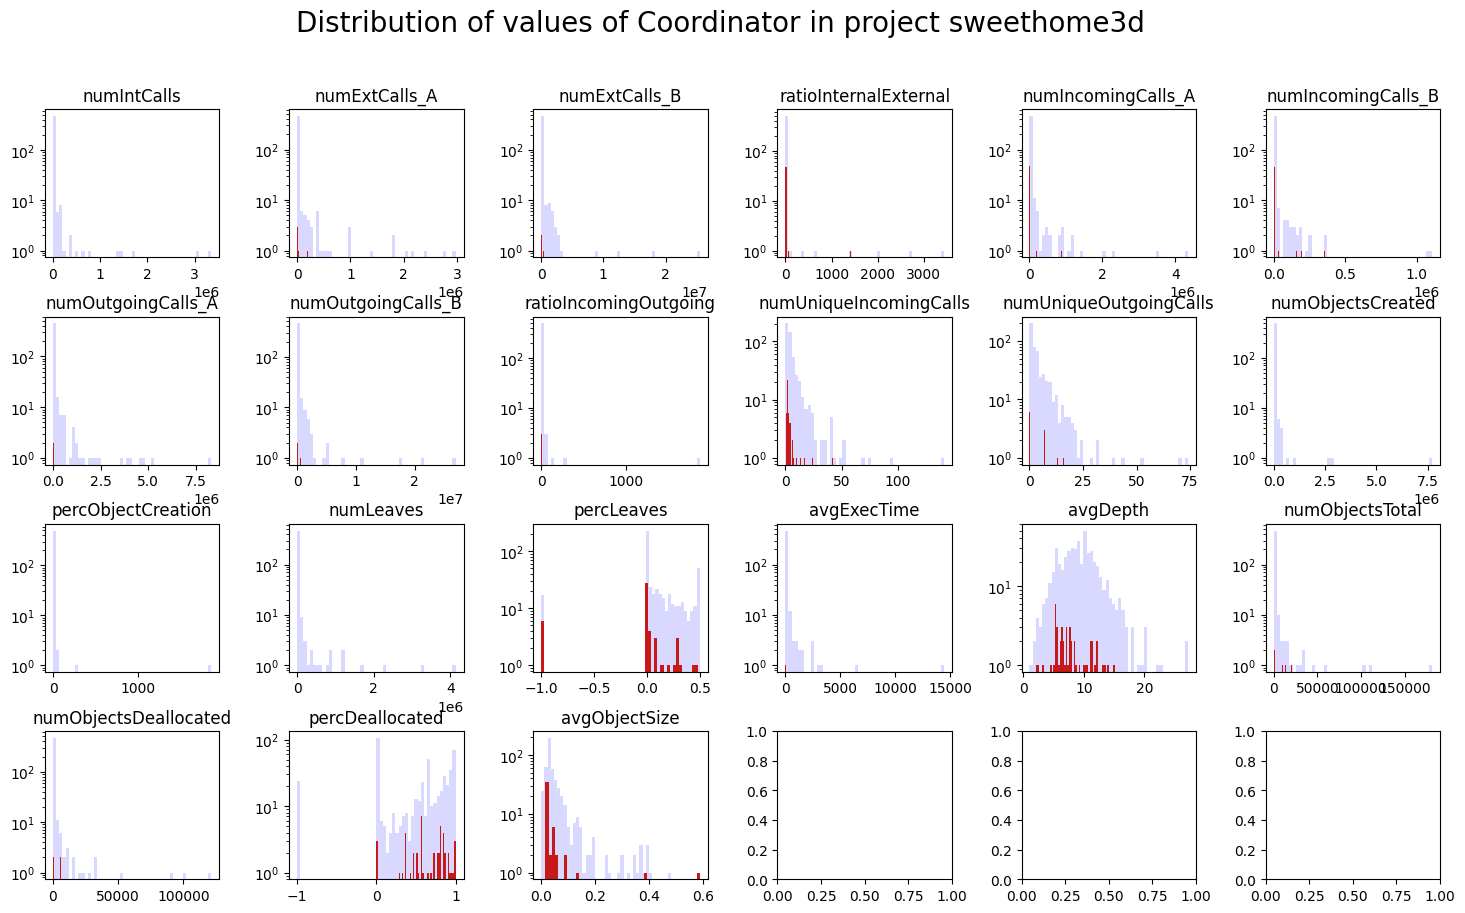

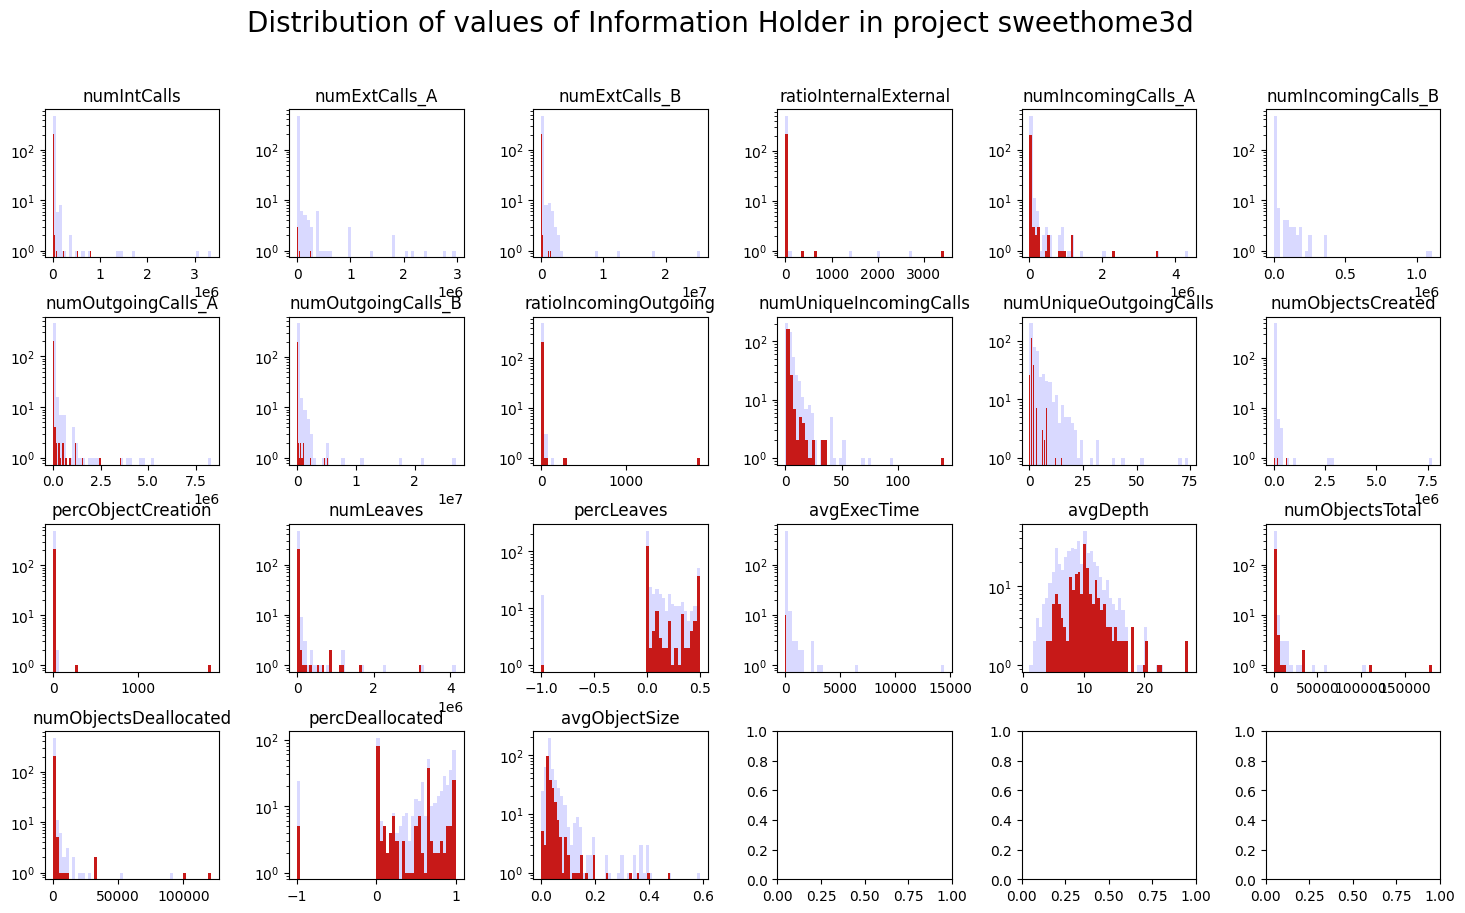

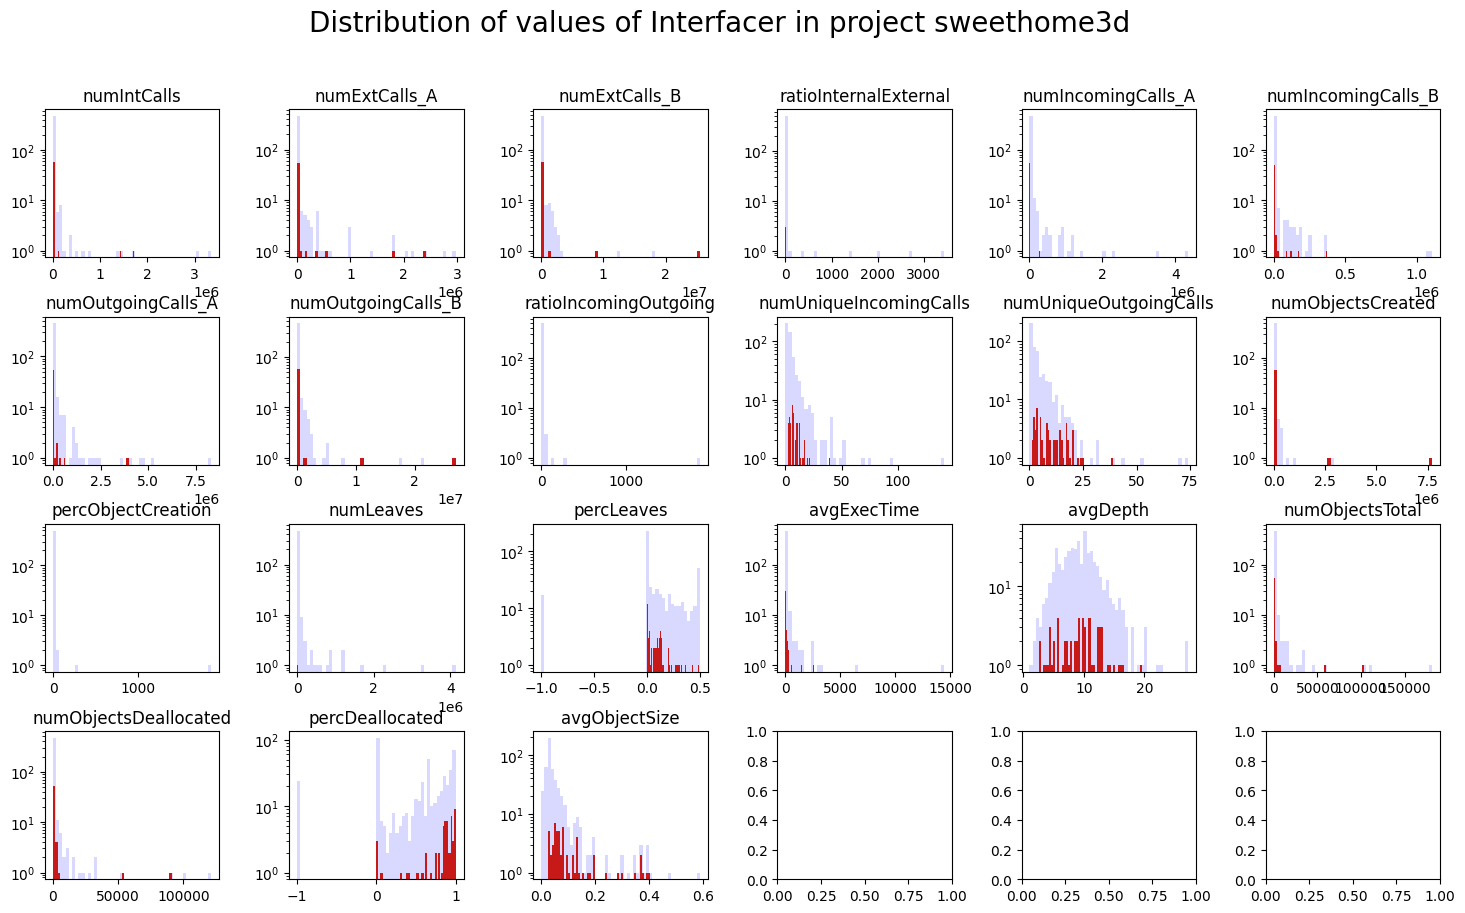

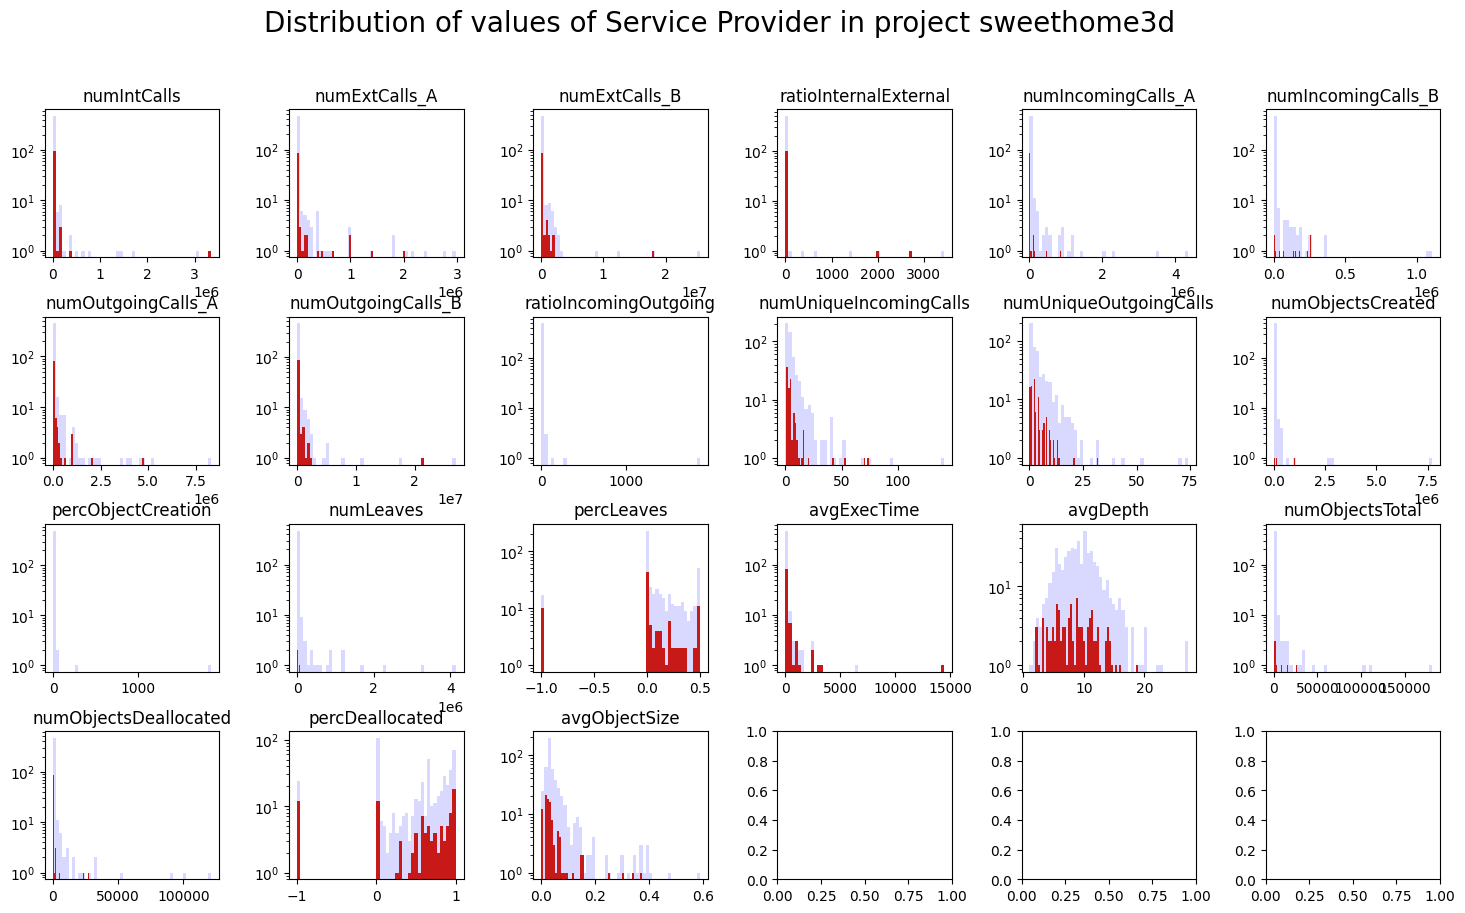

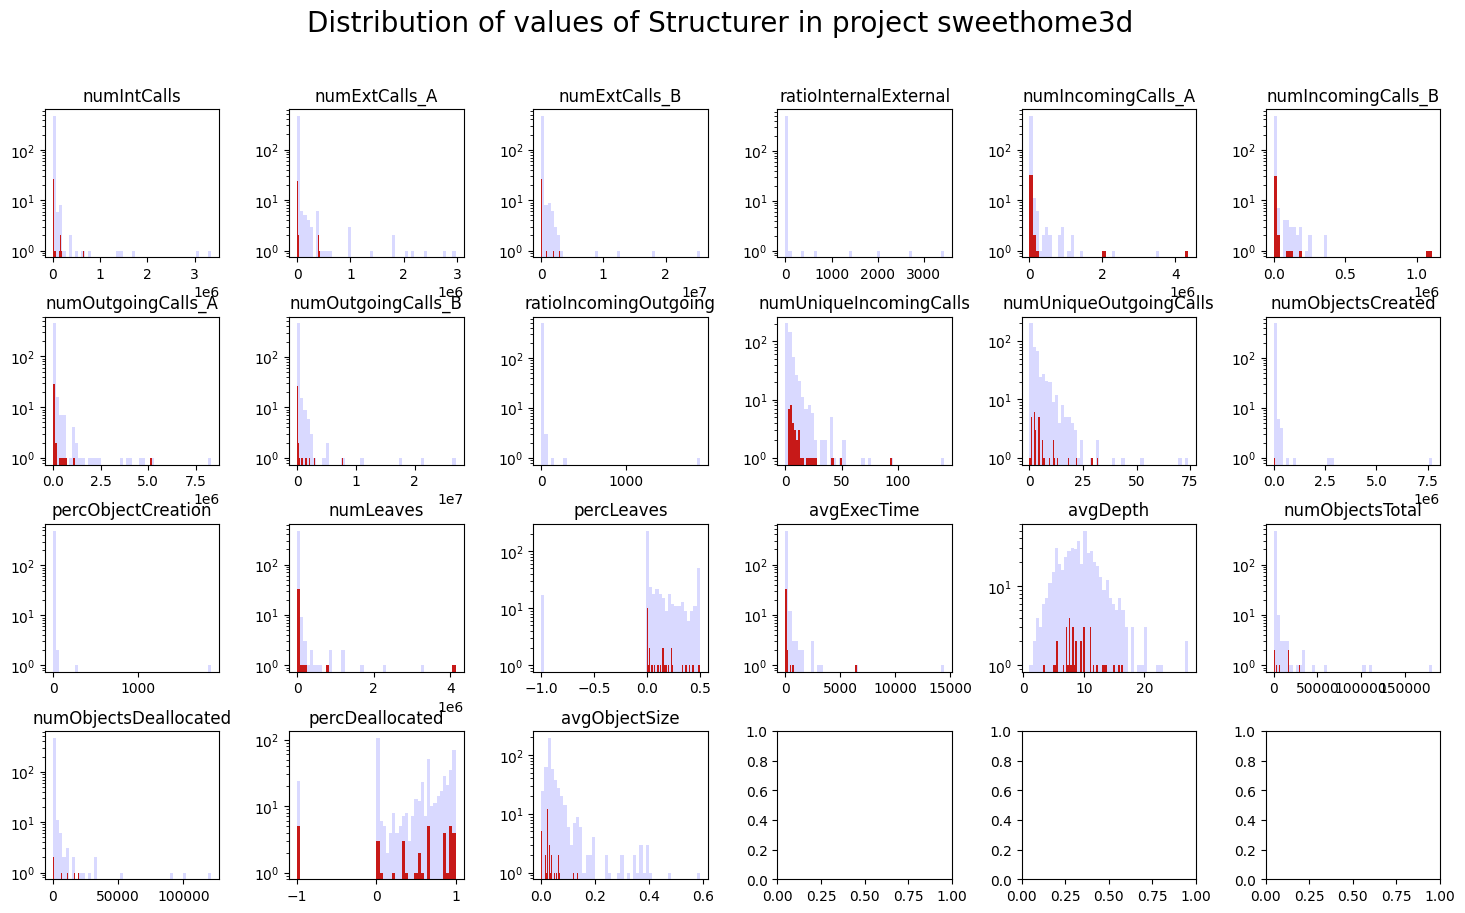

In [22]:
def plot_feat_val_dist(X, y, role):
    dataset = pd.concat([X, y], axis=1)
    X_role = dataset[dataset["label"] == role]#.drop(columns=["className"])
    X_role = X_role.drop(columns=["label"])
        
    columns = X_role.columns.tolist()
    num_features = X_role.shape[1]

    fig, axs = plt.subplots(nrows=4, ncols=6, figsize=(18, 10))
    fig.suptitle(f"Distribution of values of {role} in project {PROJECT_NAME}", fontsize=20)
    axs = axs.flatten()
    for i in range(num_features):
        col_name = columns[i]
        axs[i].hist(X[col_name], bins=50, color="blue", alpha=0.15, log=True)
        axs[i].hist(X_role[col_name], bins=50, color=PRIMARY_COLOR, log=True)
  
        axs[i].set_title(col_name)

    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()  


for role in LABELS:
    plot_feat_val_dist(X, y, role)

# Multi-class classification

#### Define method for training based on pipeline.

In [32]:
def train_pipe(pipeline, X, y, cv_strat, title):
    precision_scores = np.zeros(K)
    recall_scores = np.zeros(K)
    f1_scores = np.zeros(K)
    mcc_scores = np.zeros(K)
    
    acc_per_class = {}
    for label in LABELS:
        acc_per_class[label] = 0
    
    incorrect_predictions_all = pd.DataFrame()
    
    y_test_all = [] # For determining the confusion matrix over all folds.
    y_pred_all = []
    
    feat_importances = [] # Feature importance based on Gini scores.
    feat_importances2 = [] # Feature importances based on permutation_importance.
    
    print(f"====== CONFIG: {title} ======")
    
    for i, (train_index, test_index) in enumerate(cv_strat.split(X, y)):
        # Get training and test data.
        X_train = X.iloc[train_index]
        y_train = y.iloc[train_index]
        X_test = X.iloc[test_index]
        y_test = y.iloc[test_index]
        
        if "className" in X.columns:
            X_train = X_train.drop(columns=["className"])
            X_test = X_test.drop(columns=["className"])
        
        # Fit model and make predictions.
        clf = pipeline.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        
        # Keep track of scores.
        y_test_all.extend(y_test)
        y_pred_all.extend(y_pred)
        
        precision_scores[i] = precision_score(y_test, y_pred, average='weighted', zero_division=0)
        recall_scores[i] = recall_score(y_test, y_pred, average='weighted', zero_division=0)
        f1_scores[i] = f1_score(y_test, y_pred, average='weighted', zero_division=0)
        mcc_scores[i] = matthews_corrcoef(y_test, y_pred)
        
        # Compute accuracy per class.
        for index, label in enumerate(LABELS):
            class_acc = np.mean(y_pred[y_test == label] == label)
            acc_per_class[label] += class_acc
        
        # Print the incorrectly predicted classes, their predicted label and their true label.
        if "className" in X.columns:
            all_class_names = X.iloc[test_index]["className"]
            incorrect_indices = (y_pred != y_test)
            incorrect_predictions = all_class_names[incorrect_indices].to_frame()
            incorrect_predictions["predicted"] = y_pred[incorrect_indices]
            incorrect_predictions["true"] = y_test[incorrect_indices]
            incorrect_predictions_all = pd.concat([incorrect_predictions_all, incorrect_predictions], axis=0, ignore_index=True)
        
        # display(incorrect_predictions.groupby("true"))
        
        # # Permutation-based feature importances.
        # feat_importance_fold2 = permutation_importance(pipeline.named_steps["clf"], X_test, y_test, n_repeats=K, random_state=RANDOM_SEED)
        # feat_importances2.append(feat_importance_fold2.importances_mean)
        
        
    print("AVERAGE ACCURACY PER CLASS:")
    col_string = f""
    accuracy_string = f""
    for key, value in acc_per_class.items():
        col_string += f"{key:<{20}}"
        accuracy_string += f"{(value / K).round(ROUND):<{20}}"
    print(col_string)
    print(accuracy_string)
    
    score = {"prec": precision_scores.mean().round(ROUND), "prec_std": precision_scores.std().round(ROUND),
             "rec": recall_scores.mean().round(ROUND), "rec_std": recall_scores.std().round(ROUND),
             "f1": f1_scores.mean().round(ROUND), "f1_std": f1_scores.std().round(ROUND),
             "mcc": mcc_scores.mean().round(ROUND), "mcc_std": mcc_scores.std().round(ROUND)}
    
    print("\n")
    print("{:<10} {:<10} {:<10} {:<10}".format("PREC", "REC", "F1", "MCC"))
    print("{:<10} {:<10} {:<10} {:<10}".format(format_std(score['prec'], score['prec_std']), 
                                     format_std(score['rec'], score['rec_std']), 
                                     format_std(score['f1'], score['f1_std']), 
                                     format_std(score['mcc'], score['mcc_std'])))
    
    print("\n")
#     print("AVERAGE FEATURE IMPORTANCE (HIGH TO LOW)")
#     feat_names = pipeline.named_steps["clf"].feature_names_in_
#     average_feat_importances = np.mean(feat_importances2, axis=0)    
#     feat_importances_dict = dict(zip(feat_names, average_feat_importances))
#     feat_importances_sorted = dict(sorted(feat_importances_dict.items(), key=lambda x: x[1], reverse=True))
    
#     for feature, importance in feat_importances_sorted.items():
#         print(f"{feature}: {importance}")
#     print("\n")
    
#     if "className" in X.columns:
#         for name, group in incorrect_predictions_all.groupby("true"):
#             display(group)
    
    # ConfusionMatrixDisplay.from_predictions(y_test_all, y_pred_all, display_labels=LABELS_ABBREVIATED, labels=LABELS)
    # plt.show()

#### Train models based on our own dataset (i.e. the dynamic features).

In [79]:
# train_pipe(get_pipeline("", "svm"), X, y, cv, title="dynamic-svm")
# train_pipe(get_pipeline("smote", "svm"), X, y, cv, title="dynamic-svm-smote")
# train_pipe(get_pipeline("", "mnb"), X, y, cv, title="dynamic-mnb")
# train_pipe(get_pipeline("smote", "mnb"), X, y, cv, title="dynamic-mnb-smote")
train_pipe(get_pipeline("", "rf"), X, y, cv, title="dynamic-rf")
train_pipe(get_pipeline("smote", "rf"), X, y, cv, title="dynamic-rf-smote")

====== CONFIG: dynamic-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.5                 0.69                0.9                 0.72                0.62                0.05                


PREC       REC        F1         MCC       
0.68±0.13  0.71±0.13  0.68±0.13  0.62±0.16 


====== CONFIG: dynamic-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.57                0.69                0.85                0.69                0.54                0.33                


PREC       REC        F1         MCC       
0.71±0.15  0.68±0.14  0.67±0.14  0.61±0.18 




#### Train models based on the dataset of the paper (i.e. the static features), on 546 classes of SweetHome3D.

In [80]:
# scores_paper["svm"] = train_pipe(get_pipeline("standard", "", "svm"), X_paper, y_paper, cv)
# scores_paper["svm-smote"] = train_pipe(get_pipeline("standard", "smote", "svm"), X_paper, y_paper, cv)
# scores_paper["mnb"] = train_pipe(get_pipeline("normalizer", "", "mnb"), X_paper, y_paper, cv)
# scores_paper["mnb-smote"] = train_pipe(get_pipeline("normalizer", "smote", "mnb"), X_paper, y_paper, cv)
train_pipe(get_pipeline("", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf")
train_pipe(get_pipeline("smote", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf-smote")

====== CONFIG: static_546-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.67                0.0                 0.87                0.7                 0.8                 0.25                


PREC       REC        F1         MCC       
0.71±0.07  0.74±0.07  0.71±0.07  0.64±0.10 


====== CONFIG: static_546-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.68                0.1                 0.8                 0.73                0.71                0.3                 


PREC       REC        F1         MCC       
0.72±0.06  0.70±0.08  0.69±0.07  0.59±0.10 




#### Train models based on dataset of the paper, but only the classes there are also present in our own dataset, 501 classes of SweetHome3D.

In [85]:
# train_pipe(get_pipeline("", "svm"), X_paper_501, y_paper_501, cv, title="static_501-svm")
# train_pipe(get_pipeline("smote", "svm"), X_paper_501, y_paper_501, cv, title="static_501-svm-smote")
# train_pipe(get_pipeline("", "mnb"), X_paper_501, y_paper_501, cv, title="static_501-mnb")
# train_pipe(get_pipeline("smote", "mnb"), X_paper_501, y_paper_501, cv, title="static_501-mnb-smote")
train_pipe(get_pipeline("", "rf"), X_paper_501, y_paper_501, cv, title="static_501-rf")
train_pipe(get_pipeline("smote", "rf"), X_paper_501, y_paper_501, cv, title="static_501-rf-smote")

====== CONFIG: static_501-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.68                0.76                0.91                0.68                0.69                0.32                


PREC       REC        F1         MCC       
0.76±0.11  0.75±0.12  0.74±0.12  0.69±0.15 


====== CONFIG: static_501-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.74                0.73                0.86                0.69                0.64                0.42                


PREC       REC        F1         MCC       
0.77±0.12  0.73±0.13  0.74±0.13  0.66±0.16 




#### Train models based on the static and dynamic features combined, 501 classes of SweetHome3D.

In [90]:
# train_pipe(get_pipeline("", "svm"), X_combined, y_combined, cv, title="combined-svm")
# train_pipe(get_pipeline("smote", "svm"), X_combined, y_combined, cv, title="combined-svm-smote")
# train_pipe(get_pipeline("", "mnb"), X_combined, y_combined, cv, title="combined-mnb")
# train_pipe(get_pipeline("smote", "mnb"), X_combined, y_combined, cv, title="combined-mnb-smote")
train_pipe(get_pipeline("", "rf"), X_combined, y_combined, cv, title="combined-rf")
train_pipe(get_pipeline("smote", "rf"), X_combined, y_combined, cv, title="combined-rf-smote")

====== CONFIG: combined-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.69                0.76                0.93                0.7                 0.76                0.17                


PREC       REC        F1         MCC       
0.76±0.13  0.78±0.13  0.76±0.13  0.71±0.16 


====== CONFIG: combined-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.77                0.75                0.85                0.7                 0.68                0.33                


PREC       REC        F1         MCC       
0.77±0.13  0.74±0.14  0.74±0.14  0.68±0.18 




#### Train models based on the static featured combined with the best performing dynamic features.

In [139]:
# Static features, combined with the best dynamic features.
# display(X[["avgObjectSize", "numIncomingCalls_B", "numUniqueIncomingCalls", "numUniqueOutgoingCalls", "numLeaves"]])
X_top = pd.merge(X_paper_501, 
                 X[["className", "avgObjectSize", "numIncomingCalls_B", "numUniqueIncomingCalls", "numUniqueOutgoingCalls", "numLeaves"]],
                 on="className", how="inner")
X_top = X_top.drop(columns=["classPublicity_default", "classPublicity_protected", "classPublicity_private",
                            "numOutboundInvocation", "numMethod", "numIfs"])

train_pipe(get_pipeline("", "rf"), X_top, y_paper_501, cv, title="top-rf")
train_pipe(get_pipeline("smote", "rf"), X_top, y_paper_501, cv, title="top-rf-smote")

====== CONFIG: top-rf ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.66                0.75                0.92                0.74                0.73                0.27                


PREC       REC        F1         MCC       
0.76±0.11  0.77±0.12  0.75±0.12  0.70±0.15 


====== CONFIG: top-rf-smote ======
AVERAGE ACCURACY PER CLASS:
Controller          Coordinator         Information Holder  Interfacer          Service Provider    Structurer          
0.74                0.76                0.87                0.7                 0.72                0.5                 


PREC       REC        F1         MCC       
0.80±0.11  0.76±0.13  0.77±0.12  0.71±0.16 




# Binary classification (single role 1-vs-all)

#### Define method to extract binary datasets and training method adjusted for binary classification.

In [94]:
def extract_binary_dataset(role: str, features, labels):
    dataset = pd.concat([features, labels], axis=1)
    dataset.loc[dataset["label"] != role, "label"] = "Other"
    new_labels = dataset["label"]
    
    return features, new_labels

def train_pipe_binary(pipeline, X, y, cv_strat, title):
    print("{:<40} {:<10} {:<10} {:<10} {:<10}".format("", "PREC", "REC", "F1", "MCC"))
    
    for role in LABELS:
        X_bin, y_bin = extract_binary_dataset(role, X, y)
        
        title_new = title + "_" + role

        precision_scores = np.zeros(K)
        recall_scores = np.zeros(K)
        f1_scores = np.zeros(K)
        mcc_scores = np.zeros(K)
        
        y_test_all = [] # For plotting the calibration curve across all folds.
        y_prob_all = []
        
        feat_importances = [] # Feature importances based on permutation_importance.
        
        # y_pred_all_calib = []
        # y_prob_all_calib = []
        # calibrated_clf = CalibratedClassifierCV(pipeline, cv=5)

        for i, (train_index, test_index) in enumerate(cv_strat.split(X_bin, y_bin)):
            X_train = X_bin.iloc[train_index]
            y_train = y_bin.iloc[train_index]
            X_test = X_bin.iloc[test_index] 
            y_test = y_bin.iloc[test_index]
            
            if "className" in X.columns:
                X_train = X_train.drop(columns=["className"])
                X_test = X_test.drop(columns=["className"])
        
            clf = pipeline.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            # y_prob = clf.predict_proba(X_test)[:,1]
            
            y_test_all.extend(y_pred)
            # y_prob_all.extend(y_prob)
            
            # # Permutation-based feature importances.
            # feat_importance_fold = permutation_importance(pipeline.named_steps["clf"], X_test, y_test, n_repeats=K, random_state=RANDOM_SEED)
            # feat_importances.append(feat_importance_fold.importances_mean)
            
#             calibrated_clf = CalibratedClassifierCV(clf, cv="prefit")
#             calibrated_clf.fit(X_train, y_train)
#             y_pred_calib = calibrated_clf.predict(X_test)
#             y_prob_calib = calibrated_clf.predict_proba(X_test)[:,1]
#             y_pred_all_calib.extend(y_pred_calib)
#             y_prob_all_calib.extend(y_prob_calib)

            precision_scores[i] = precision_score(y_test, y_pred, average='binary', pos_label=role, zero_division=0)
            recall_scores[i] = recall_score(y_test, y_pred, average='binary', pos_label=role, zero_division=0)
            f1_scores[i] = f1_score(y_test, y_pred, average='binary', pos_label=role, zero_division=0)
            mcc_scores[i] = matthews_corrcoef(y_test, y_pred)

        score = {"prec": precision_scores.mean().round(ROUND), "prec_std": precision_scores.std().round(ROUND),
                 "rec": recall_scores.mean().round(ROUND), "rec_std": recall_scores.std().round(ROUND),
                 "f1": f1_scores.mean().round(ROUND), "f1_std": f1_scores.std().round(ROUND),
                 "mcc": mcc_scores.mean().round(ROUND), "mcc_std": mcc_scores.std().round(ROUND)}
        
#         print("---Permutation-based---")
#         feat_names = pipeline.named_steps["clf"].feature_names_in_
#         average_feat_importances = np.mean(feat_importances, axis=0)    
#         feat_importances_dict = dict(zip(feat_names, average_feat_importances))
#         feat_importances_sorted = dict(sorted(feat_importances_dict.items(), key=lambda x: x[1], reverse=True))

#         for feature, importance in feat_importances_sorted.items():
#             print(f"{feature}: {importance}")
#         print("\n")

        # CalibrationDisplay.from_predictions(y_test_all, y_prob_all, n_bins=15, strategy="quantile", pos_label=role)
        # plt.show()
        # CalibrationDisplay.from_predictions(y_test_all, y_prob_all_calib, n_bins=15, strategy="quantile", pos_label=role)
        # plt.show()
        
        print("{:<40} {:<10} {:<10} {:<10} {:<10}".format(title_new,
                                         format_std(score['prec'], score['prec_std']), 
                                         format_std(score['rec'], score['rec_std']), 
                                         format_std(score['f1'], score['f1_std']), 
                                         format_std(score['mcc'], score['mcc_std'])))

#### Train models based on our own dataset (i.e. the dynamic features).

In [95]:
train_pipe_binary(get_pipeline("", "rf"), X, y, cv, title="dynamic-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X, y, cv, title="dynamic-rf-smote")

                                         PREC       REC        F1         MCC       
dynamic-rf_Controller                    0.65±0.45  0.39±0.32  0.48±0.35  0.49±0.35 
dynamic-rf_Coordinator                   0.97±0.07  0.49±0.26  0.61±0.23  0.63±0.19 
dynamic-rf_Information Holder            0.92±0.10  0.81±0.11  0.86±0.09  0.80±0.12 
dynamic-rf_Interfacer                    0.89±0.15  0.54±0.14  0.66±0.14  0.65±0.14 
dynamic-rf_Service Provider              0.76±0.35  0.40±0.39  0.45±0.38  0.44±0.38 
dynamic-rf_Structurer                    0.10±0.30  0.05±0.15  0.07±0.20  0.07±0.21 
                                         PREC       REC        F1         MCC       
dynamic-rf-smote_Controller              0.48±0.32  0.44±0.31  0.44±0.28  0.42±0.29 
dynamic-rf-smote_Coordinator             0.74±0.18  0.65±0.26  0.64±0.17  0.62±0.17 
dynamic-rf-smote_Information Holder      0.89±0.12  0.84±0.09  0.86±0.08  0.80±0.12 
dynamic-rf-smote_Interfacer              0.74±0.18  0.70±0.17  0.

#### Train models based on the dataset of the paper (i.e. the static features), on 546 classes of SweetHome3D.

In [96]:
train_pipe_binary(get_pipeline("", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_paper_546, y_paper_546, cv, title="static_546-rf-smote")

                                         PREC       REC        F1         MCC       
static_546-rf_Controller                 0.84±0.31  0.62±0.38  0.66±0.33  0.68±0.31 
static_546-rf_Coordinator                0.00±0.00  0.00±0.00  0.00±0.00  0.00±0.00 
static_546-rf_Information Holder         0.88±0.14  0.82±0.15  0.83±0.10  0.73±0.16 
static_546-rf_Interfacer                 0.84±0.23  0.51±0.19  0.60±0.16  0.60±0.17 
static_546-rf_Service Provider           0.78±0.15  0.65±0.12  0.70±0.11  0.60±0.15 
static_546-rf_Structurer                 0.40±0.49  0.15±0.20  0.21±0.27  0.23±0.30 
                                         PREC       REC        F1         MCC       
static_546-rf-smote_Controller           0.62±0.26  0.72±0.34  0.66±0.29  0.65±0.30 
static_546-rf-smote_Coordinator          0.02±0.05  0.05±0.15  0.02±0.08  -0.01±0.09
static_546-rf-smote_Information Holder   0.87±0.15  0.85±0.13  0.84±0.10  0.74±0.18 
static_546-rf-smote_Interfacer           0.72±0.23  0.71±0.16  0.

#### Train models based on dataset of the paper, but only the classes there are also present in our own dataset, 501 classes of SweetHome3D.

In [97]:
train_pipe_binary(get_pipeline("", "rf"), X_paper_501, y_paper_501, cv, title="static_501-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_paper_501, y_paper_501, cv, title="static_501-rf-smote")

                                         PREC       REC        F1         MCC       
static_501-rf_Controller                 0.71±0.41  0.60±0.40  0.63±0.39  0.63±0.39 
static_501-rf_Coordinator                0.92±0.16  0.69±0.22  0.77±0.19  0.76±0.19 
static_501-rf_Information Holder         0.94±0.07  0.80±0.14  0.86±0.10  0.81±0.12 
static_501-rf_Interfacer                 0.84±0.22  0.58±0.15  0.65±0.13  0.63±0.15 
static_501-rf_Service Provider           0.69±0.31  0.44±0.31  0.52±0.31  0.45±0.35 
static_501-rf_Structurer                 0.15±0.32  0.17±0.34  0.15±0.29  0.15±0.30 
                                         PREC       REC        F1         MCC       
static_501-rf-smote_Controller           0.59±0.24  0.79±0.29  0.62±0.20  0.62±0.22 
static_501-rf-smote_Coordinator          0.77±0.20  0.71±0.21  0.72±0.17  0.69±0.20 
static_501-rf-smote_Information Holder   0.92±0.10  0.85±0.14  0.87±0.10  0.83±0.12 
static_501-rf-smote_Interfacer           0.73±0.28  0.65±0.18  0.

#### Train models based on the static and dynamic features combined, 501 classes of SweetHome3D.

In [98]:
train_pipe_binary(get_pipeline("", "rf"), X_combined, y_combined, cv, title="combined-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_combined, y_combined, cv, title="combined-rf-smote")

                                         PREC       REC        F1         MCC       
combined-rf_Controller                   0.63±0.46  0.57±0.43  0.60±0.44  0.60±0.44 
combined-rf_Coordinator                  0.97±0.10  0.62±0.22  0.73±0.18  0.73±0.17 
combined-rf_Information Holder           0.96±0.08  0.78±0.11  0.86±0.08  0.81±0.10 
combined-rf_Interfacer                   0.86±0.24  0.53±0.14  0.65±0.17  0.63±0.20 
combined-rf_Service Provider             0.53±0.46  0.33±0.37  0.38±0.39  0.36±0.40 
combined-rf_Structurer                   0.10±0.30  0.05±0.15  0.07±0.20  0.07±0.21 
                                         PREC       REC        F1         MCC       
combined-rf-smote_Controller             0.60±0.34  0.66±0.37  0.63±0.35  0.60±0.37 
combined-rf-smote_Coordinator            0.85±0.18  0.72±0.23  0.75±0.19  0.74±0.20 
combined-rf-smote_Information Holder     0.94±0.07  0.86±0.10  0.89±0.06  0.85±0.07 
combined-rf-smote_Interfacer             0.79±0.18  0.71±0.13  0.

#### Train models based on the static featured combined with the best performing dynamic features.

In [99]:
train_pipe_binary(get_pipeline("", "rf"), X_top, y_paper_501, cv, title="combined-rf")
train_pipe_binary(get_pipeline("smote", "rf"), X_top, y_paper_501, cv, title="combined-rf-smote")

                                         PREC       REC        F1         MCC       
combined-rf_Controller                   0.61±0.45  0.57±0.43  0.59±0.43  0.58±0.43 
combined-rf_Coordinator                  0.93±0.14  0.69±0.19  0.78±0.16  0.77±0.17 
combined-rf_Information Holder           0.95±0.06  0.83±0.11  0.88±0.08  0.84±0.09 
combined-rf_Interfacer                   0.82±0.19  0.58±0.16  0.66±0.15  0.63±0.17 
combined-rf_Service Provider             0.66±0.31  0.45±0.36  0.50±0.33  0.45±0.35 
combined-rf_Structurer                   0.10±0.30  0.10±0.30  0.10±0.30  0.10±0.30 
                                         PREC       REC        F1         MCC       
combined-rf-smote_Controller             0.57±0.33  0.69±0.42  0.59±0.33  0.58±0.34 
combined-rf-smote_Coordinator            0.77±0.15  0.76±0.17  0.75±0.13  0.72±0.15 
combined-rf-smote_Information Holder     0.94±0.08  0.88±0.13  0.90±0.08  0.87±0.09 
combined-rf-smote_Interfacer             0.75±0.21  0.75±0.15  0.

# Generalisability test (train on SweetHome3D, evaluate on JHotDraw)

#### Load data.

In [152]:
PROJECT_NAME = "jhotdraw"

# Dynamic features.
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/features_{PROJECT_NAME}_FINAL_v2.csv"
X_JHD, y_JHD, data_JHD = load_data(data_path)

# Drop all isEnum classes.
data_without_enum = pd.merge(data, X_paper_501[["className", "isEnum"]], on='className', how='inner')
data_without_enum = data_without_enum[data_without_enum["isEnum"] == 0]
y_wo_enum = data_without_enum["label"]
X_wo_enum = data_without_enum.drop(columns=["isEnum", "className", "label"])


# Static features.         
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/static_features_{PROJECT_NAME}_FINAL_v2.csv"
cat_features = ["classPublicity"]
X_JHD_static, y_JHD_static, data_JHD_static = load_data(data_path, cat_features=cat_features)
X_JHD_static["classPublicity_private"] = 0 # In training set, we do have private and protected classes, but not in this test set but the model still requires us to fill them in with all-0.
X_JHD_static["classPublicity_protected"] = 0
X_JHD_static = X_JHD_static.reindex(columns=X_paper_501.columns.tolist()[1:]) # Set columns in the same order as the training set to prevent errors.

# Drop all isEnum classes.
data2 = pd.concat([X_paper_501, y_paper_501], axis=1)
data_without_enum2 = data2[data2["isEnum"] == 0]
y_wo_enum2 = data_without_enum2["label"]
X_wo_enum2 = data_without_enum2.drop(columns=["className", "label"])
X_wo_enum2["classPublicity_private"] = 0 
X_wo_enum2["classPublicity_protected"] = 0


# Combined features
data_path = f"/Users/mboopi/Documents/GitHub/JavaClassClassification/data/dataset/{PROJECT_NAME}/static_features_{PROJECT_NAME}_FINAL_v2.csv"
cat_features = ["classPublicity"]
X_JHD_static, y_JHD_static, data_JHD_static = load_data(data_path, cat_features=cat_features)
X_JHD_static["classPublicity_private"] = 0 # In training set, we do have private and protected classes, but not in this test set but the model still requires us to fill them in with all-0.
X_JHD_static["classPublicity_protected"] = 0
X_JHD_static = X_JHD_static.reindex(columns=X_paper_501.columns.tolist()[1:]) # Set columns in the same order as the training set to prevent errors.

data_JHD_combined = pd.merge(data_JHD, data_JHD_static, on="className", how="inner")
y_JHD_combined = data_JHD_combined["label_x"]
y_JHD_combined.name = "label"
X_JHD_combined = data_JHD_combined.drop(columns=["label_y", "label_x"])
X_JHD_combined["classPublicity_private"] = 0
X_JHD_combined["classPublicity_protected"] = 0
X_JHD_combined = X_JHD_combined.reindex(columns=X_combined.columns.tolist()[1:])

#### Training setup.

In [103]:
def train_general(X_train, y_train, X_test, y_test, pipeline, title):
    if "className" in X_train.columns:
        X_train = X_train.drop(columns=["className"])
    if "className" in X_test.columns:
        X_test = X_test.drop(columns=["className"])

    # Fit model and make predictions.
    clf = pipeline.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Compute scores.
    prec = precision_score(y_test, y_pred, average='weighted', zero_division=0).round(ROUND)
    rec = recall_score(y_test, y_pred, average='weighted', zero_division=0).round(ROUND)
    f1 = f1_score(y_test, y_pred, average='weighted', zero_division=0).round(ROUND)
    mcc = matthews_corrcoef(y_test, y_pred).round(ROUND)
    
    print("{:<20} {:<10} {:<10} {:<10} {:<10}".format("", "PREC", "REC", "F1", "MCC"))
    print("{:<20} {:<10} {:<10} {:<10} {:<10}".format(title, prec, rec, f1, mcc))
    print("\n")
         
    # ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=LABELS_ABBREVIATED, labels=LABELS)
    # plt.show()

#### Evaluate generalisability dynamic features.

In [126]:
train_general(X, y, X_JHD, y_JHD, get_pipeline("", "rf"), title="dynamic")
train_general(X, y, X_JHD, y_JHD, get_pipeline("smote", "rf"), title="dynamic-smote")

# Without enums.
train_general(X_wo_enum, y_wo_enum, X_JHD, y_JHD, get_pipeline("", "rf"), title="dynamic-w/o-enum")
train_general(X_wo_enum, y_wo_enum, X_JHD, y_JHD, get_pipeline("smote", "rf"), title="dynamic-w/o-enum-smote")

                     PREC       REC        F1         MCC       
dynamic              0.44       0.33       0.29       0.21      


                     PREC       REC        F1         MCC       
dynamic-smote        0.42       0.33       0.29       0.2       


                     PREC       REC        F1         MCC       
dynamic-w/o-enum     0.36       0.3        0.26       0.18      


                     PREC       REC        F1         MCC       
dynamic-w/o-enum-smote 0.35       0.31       0.26       0.19      




#### Evaluate generalisability static features.

In [137]:
train_general(X_paper_501, y_paper_501, X_JHD_static, y_JHD_static, get_pipeline("", "rf"), title="static")
train_general(X_paper_501, y_paper_501, X_JHD_static, y_JHD_static, get_pipeline("smote", "rf"), title="static-smote")

# Without enums.
train_general(X_wo_enum2, y_wo_enum2, X_JHD_static, y_JHD_static, get_pipeline("", "rf"), title="static-w/o-enum")
train_general(X_wo_enum2, y_wo_enum2, X_JHD_static, y_JHD_static, get_pipeline("smote", "rf"), title="static-w/o-enum-smote")

                     PREC       REC        F1         MCC       
static               0.28       0.16       0.09       0.09      


                     PREC       REC        F1         MCC       
static-smote         0.37       0.22       0.22       0.11      


                     PREC       REC        F1         MCC       
static-w/o-enum      0.04       0.15       0.06       0.09      


                     PREC       REC        F1         MCC       
static-w/o-enum-smote 0.45       0.22       0.2        0.15      




#### Evaluate generalisability combined features.

In [151]:
train_general(X_combined, y_combined, X_JHD_combined, y_JHD_combined, get_pipeline("", "rf"), title="combined")
train_general(X_combined, y_combined, X_JHD_combined, y_JHD_combined, get_pipeline("smote", "rf"), title="combined-smote")

                     PREC       REC        F1         MCC       
combined             0.31       0.17       0.11       0.11      


                     PREC       REC        F1         MCC       
combined-smote       0.33       0.25       0.21       0.19      




#### Evaluate generalisability static + best dynamic features.

In [165]:
X_JHD_top = pd.merge(data_JHD_static.drop(columns=["label"]), 
                 X_JHD[["className", "avgObjectSize", "numIncomingCalls_B", "numUniqueIncomingCalls", "numUniqueOutgoingCalls", "numLeaves"]],
                 on="className", how="inner")
X_JHD_top = X_JHD_top.drop(columns=["classPublicity_default",
                            "numOutboundInvocation", "numMethod", "numIfs"])

train_general(X_top, y_paper_501, X_JHD_top, y_JHD_static, get_pipeline("", "rf"), title="combined")
train_general(X_top, y_paper_501, X_JHD_top, y_JHD_static, get_pipeline("smote", "rf"), title="combined-smote")

                     PREC       REC        F1         MCC       
combined             0.04       0.15       0.06       0.09      


                     PREC       REC        F1         MCC       
combined-smote       0.41       0.21       0.17       0.16      


